In [96]:
import numpy as np
import rawpy as rp
import matplotlib.pyplot as plt
import image_conversions as imc
from scipy.stats import expon, poisson, uniform
import os
from PIL import Image

In [2]:
# 1. algo de dématriçage : LINEAR, AHD, VNG, PPG, DCB, DHT
# 2. paramètre hétéroscédastique 'a' [.1, 2]
# 3. Nombre de passe du filtre médian

In [3]:
img = rp.imread("im.dng")

In [17]:
params=rp.Params(rp.DemosaicAlgorithm.DHT, half_size=False, four_color_rgb=False, 
                    use_camera_wb=True, use_auto_wb=False,user_wb=(1,1,1,1), 
                    output_color=rp.ColorSpace.raw, output_bps=16, 
                    user_flip=None, user_black=0, user_sat=None, 
                    no_auto_bright=True, auto_bright_thr=None, 
                    adjust_maximum_thr=0.0, bright=1.0, 
                    highlight_mode=rp.HighlightMode.Clip,  gamma=(1,1),
                    exp_shift=None, exp_preserve_highlights=0.0, no_auto_scale=False,
                    chromatic_aberration=None, bad_pixels_path=None,median_filter_passes=0)
p = img.postprocess(params)

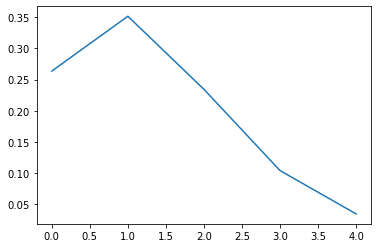

In [68]:
mu = 4/3
x = np.arange(poisson.ppf(.01, mu=mu), poisson.ppf(.99, mu=mu))
d = poisson.pmf(x, mu=mu)
plt.plot(x, d)
plt.show()

In [124]:
n_img = 2
lvl_max = 65535
demosaicing = [rp.DemosaicAlgorithm.LINEAR, 
               rp.DemosaicAlgorithm.AHD, 
               rp.DemosaicAlgorithm.VNG, 
               rp.DemosaicAlgorithm.PPG, 
               rp.DemosaicAlgorithm.DCB, 
               rp.DemosaicAlgorithm.DHT]
mu = 4/3 #poisson parameter for number of mean filter passes
het_min, het_max = .1, 2 # boundaries for uniform distrib for heteroscedastic parameter
b = 0
qmtx = np.ones((8,8))
outpath_img = "image-set/images/"
outpath_cov = "image-set/covars/"
outpath_param = "image-set/params/"
base_img = 'im.dng'

In [145]:
def synchronize_grid(r1, r2):
    for i in np.arange(2):
        for j in np.arange(2):
            if (r1[i:i+4,j:j+4] == r2).all():
                return(i,j)
    print("Could not synchronize the grid")
    return (None)


def special_center_crop(im, newWidth, newHeight, add_margin=0):
    width, height = im.shape[0:2] #get dimensions
    if newWidth > width or newHeight > height:
        newWidth, newHeight = newHeight, newWidth
        
    #Compute the first and last indices of pixels' central area
    left = (width - newWidth) // 2
    top = (height - newHeight) // 2
    right = (width + newWidth) // 2
    bottom = (height + newHeight) // 2
    #Return the pixels from this area
    if add_margin == 1:
        return(im[left-1:right+1, top-1:bottom+1])
    elif add_margin == 3:
        return(im[left-9:right+9, top-9:bottom+9])
    elif add_margin ==24:
        return(im[left-24:right+24, top-24:bottom+24])
    elif add_margin == '4latboss':
        return(im[left-24-9:right+72+9, top-24-9:bottom+72+9])
    elif add_margin == '4latlin':
        return(im[left-8-9:right+24+9, top-8-9:bottom+24+9])
    elif add_margin == 0:
        return (im[left:right, top:bottom])
    else: 
        print("Unimplemented margin")
        return (None)
    

def  develop_multivar(im, a, b, params):
    RAW_im = rp.imread(im)
    crop_shape = 264
    print(RAW_im.raw_image_visible.shape)
    #print(type(RAW_im.raw_colors_visible))
    tmp = np.copy(RAW_im.raw_image_visible[:,:])
    #colors = np.copy(RAW_im.raw_colors_visible[:,:])
    raw_crop = special_center_crop(tmp, crop_shape,crop_shape, add_margin='4latboss')
    #color_crop = special_center_crop(color, 1920,1920, add_margin='4latboss')
    #(off_x, off_y) = synchronize_grid(color_crop[:8,:8], RAW_im.raw_color_visible[:4,:4])
    off_x, off_y = 0,0
    (h, w) = RAW_im.raw_image_visible.shape[:2]
    (hc, wc) = raw_crop.shape[:2]
    for i in range(h//hc):
        for j in range(w//wc):
            RAW_im.raw_image_visible[off_x+i*hc:off_x+(i+1)*hc, off_y+j*wc:off_y+(j+1)*wc] = raw_crop  
    sensor_noise =a*RAW_im.raw_image_visible[:,:] + b
    sensor_noise[sensor_noise < 0] = 0
    new_im = np.round(np.random.normal(loc=RAW_im.raw_image_visible[:,:], scale=np.sqrt(sensor_noise)))
    new_im[new_im < 0] = 0
    new_im[new_im > lvl_max] = lvl_max
    RAW_im.raw_image_visible[:,:] = new_im
    hc2, wc2 = hc-18, wc-18
    rgb = RAW_im.postprocess(params)
    greys = []
    for i in range(h//hc):
        for j in range(w//wc):
            grey = imc.rgb2gray(rgb[off_x+i*hc:off_x+(i+1)*hc, off_y+j*wc:off_y+(j+1)*wc] / (2**16-1) * 255) [9:-9, 9:-9]
            #res_im = np.array(Image.fromarray(grey[:,:]).resize((hc2//3, wc2//3), Image.LANCZOS))
            jim = imc.compute_dct_domain(grey, np.ones((8,8)))
            greys.append(jim)
    return greys

In [146]:
params = rp.Params(rp.DemosaicAlgorithm.AHD, half_size=False, four_color_rgb=False, 
                    use_camera_wb=True, use_auto_wb=False,user_wb=(1,1,1,1), 
                    output_color=rp.ColorSpace.raw, output_bps=16, 
                    user_flip=None, user_black=0, user_sat=None, 
                    no_auto_bright=True, auto_bright_thr=None, 
                    adjust_maximum_thr=0.0, bright=1.0, 
                    highlight_mode=rp.HighlightMode.Clip,  gamma=(1,1),
                    exp_shift=None, exp_preserve_highlights=0.0, no_auto_scale=False,
                    chromatic_aberration=None, bad_pixels_path=None,median_filter_passes=0)
lst = develop_multivar('im.dng', 1, 0, params)

(4000, 6000, 4)


<class 'numpy.ndarray'>
(360, 360)
(360, 360)


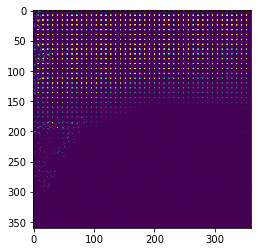

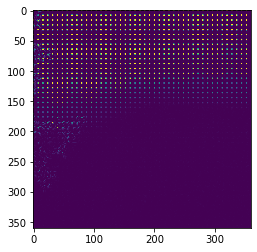

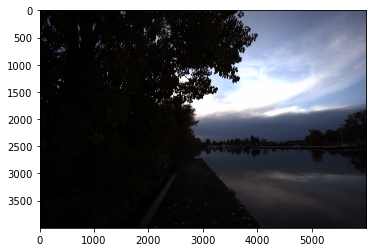

In [147]:
print(type(lst[0]))
print(lst[0].shape)
print(lst[1].shape)
plt.imshow(lst[0], vmin=0, vmax=100)
plt.show()
plt.imshow(lst[1], vmin=0, vmax=100)
plt.show()
params = rp.Params(rp.DemosaicAlgorithm.AHD, half_size=False, four_color_rgb=False, 
                    use_camera_wb=True, use_auto_wb=False,user_wb=(1,1,1,1), 
                    output_color=rp.ColorSpace.raw, output_bps=16, 
                    user_flip=None, user_black=0, user_sat=None, 
                    no_auto_bright=True, auto_bright_thr=None, 
                    adjust_maximum_thr=0.0, bright=1.0, 
                    highlight_mode=rp.HighlightMode.Clip,  gamma=(1,1),
                    exp_shift=None, exp_preserve_highlights=0.0, no_auto_scale=False,
                    chromatic_aberration=None, bad_pixels_path=None,median_filter_passes=0)
test = rp.imread('im.dng')
plt.imshow((test.postprocess(params)/(2**16-1)*255).astype(np.int32))
plt.show()

In [86]:
max_level = 65535

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


def crop(im, crop_shape, gray=True):
    h0 = int(np.round( (im.shape[0] - crop_shape[0]) / 2 ))
    w0 = int(np.round( (im.shape[1] - crop_shape[1]) / 2 ))
    
    if gray:
        if len(im.shape) == 3 and im.shape[2] == 3:
            cropped_im = rgb2gray(im)[h0:h0+crop_shape[0], w0:w0+crop_shape[1]]
        elif len(im.shape) == 3 and im.shape[2] == 1:
            cropped_im = im[h0:h0+crop_shape[0], w0:w0+crop_shape[1],]
        else:
            cropped_im = im[h0:h0+crop_shape[0], w0:w0+crop_shape[1]]
    else:
        cropped_im = im[h0:h0+crop_shape[0], w0+w0+crop_shape[1],:]
        
    return cropped_im


def develop(fname, params, a, b):
    
    RAW_im = rp.imread(fname)
    noise = a*RAW_im.raw_image_visible[:,:]+b
    noise[noise < 0] = 0
    
    NEW_im = np.round(np.random.normal(loc=RAW_im.raw_image_visible[:,:], scale=np.sqrt(noise)))
    NEW_im[NEW_im < 0] = 0
    NEW_im[NEW_im > max_level] = max_level
    RAW_im.raw_image_visible[:,:] = NEW_im
    
    #(h,w) = RAW_im.raw_image_visible.shape
    
    rgb = RAW_im.postprocess(params)
    crop_shape = (264,264)
    
    gray = crop(rgb, crop_shape)
    
    return gray

In [93]:
for im_id in range(n_img):
    # 1. Generate params
    print("Generate params")
    demo = np.random.choice(demosaicing)
    n_passes = poisson.rvs(mu)
    a = uniform.rvs(loc=het_min, scale=het_max)
    
    # 2. Set parameters
    print("Set parameters")
    params = rp.Params(demo, half_size=False, four_color_rgb=False, 
                    use_camera_wb=True, use_auto_wb=False,user_wb=(1,1,1,1), 
                    output_color=rp.ColorSpace.raw, output_bps=16, 
                    user_flip=None, user_black=0, user_sat=None, 
                    no_auto_bright=True, auto_bright_thr=None, 
                    adjust_maximum_thr=0.0, bright=1.0, 
                    highlight_mode=rp.HighlightMode.Clip,  gamma=(1,1),
                    exp_shift=None, exp_preserve_highlights=0.0, no_auto_scale=False,
                    chromatic_aberration=None, bad_pixels_path=None,median_filter_passes=n_passes)
    
    # 3. Develop 100 images
    print("Develop images")
    imgs, dcts = [], []
    imgs8, imgs24 = [], []
    for i in range(2):
        img = develop(base_img, params, a, b)
        imgs.append(img)
        dcts.append(imc.compute_dct_domain(img / (2**16-1) * 255, qmtx))
        
        imgs8.append(imc.block_row_scan(dcts[-1], k=1))
        #imgs24.append(imc.block_row_scan(dct[-1], k=3))
    imgs8 = np.asarray(imgs8)
    
    # 4. Compute Covariance matrix over these
    print("Compute covariance")
    #imgs24 = np.asarray(imgs24)
    C8, C24 = [], []
    for i in range(imgs8.shape[1]):
        for j in range(imgs8.shape[2]):
            C8.append(np.cov(imgs8[:,i,j,:].T,))
    C8 = np.asarray(C8)
    
    #for i in range(imgs24.shape[1]):
    #    for j in range(imgs24.shape[2]):
    #        C24.append(np.cov(imgs24[:,i,j,:].T,))
    #C24 = np.asarray(C24)
        
    # 5. Save 1 image and the corresponding cov mtx
    print("save")
    np.save(os.path.join("image-set/covars/", str(im_id)), C8)
    np.save(os.path.join("image-set/images/", str(im_id)), imgs[0])
    

Generate params
Set parameters
Develop images
Compute covariance
save
Generate params
Set parameters
Develop images
Compute covariance
save


In [74]:
print(np.random.choice(demosaicing))
n_passes = poisson.rvs(mu)
a = uniform.rvs(loc=het_min, scale=het_max)
print(n_passes, a)

DemosaicAlgorithm.DHT
3 0.3968142220663594
